In [1]:
import numpy as np
from itertools import combinations

def sample(n: int, contextual:bool = True):
    table = np.random.uniform(0,1,(4,n))
    table[:,0] /= np.sum(table[:,0])
    for idx in range(n):
        next_idx = (idx+1) % n
        table[[0,1], next_idx] = table[[0,1], next_idx] * np.sum(table[[0,2],idx]) / np.sum(table[[0,1],next_idx])
        table[[2,3], next_idx] = table[[2,3], next_idx] * np.sum(table[[1,3],idx]) / np.sum(table[[2,3],next_idx])    
    return table
     

def get_coefs(n):
    for i in np.arange(1,n+2,2):
        comb = list(combinations(np.arange(n), i))
        buf = np.ones((len(comb), n))
        for idx, c in enumerate(comb):
            buf[idx, c] *= -1
        coefs = buf if not 'coefs' in locals() else np.vstack((coefs, buf))
    return coefs

def E(table):
    return np.tile(table[0, :] + table[3, :] - table[1, :] - table[2, :], (2**(table.shape[1]-1), 1))

def check_noncontexuality(table):
    n = table.shape[1]
    results = np.sum(np.multiply(E(table), get_coefs(n)), axis = 1)
    #print(results.shape)
    return np.all(results <= n-2), results

In [2]:
def sampler(num:int = 10000, dim:int = 5, noncontextual:bool = True):
    samples = list()
    while len(samples) < num:
        s = sample(dim)
        if noncontextual == check_noncontexuality(s)[0]:
            samples.append(s)
            if len(samples) % 1000 == 0:
                print(len(samples))
    return samples

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.y)

# Simple classifier

In [149]:
num = 5000
noncontextual = sampler(num, 5, True)
contextual = np.load('contectual.npy')
data_X = np.concatenate((noncontextual, contextual))
m1 = np.concatenate((np.zeros(num), np.array(list(map(lambda x: NL(x, noncontextual), contextual)))))
m2 = np.concatenate((np.zeros(num), np.ones(num)))
data_y = np.transpose(np.vstack((m1,m2)))

1000
2000
3000
4000
5000


In [150]:
class mlp(nn.Module):
    def __init__(self, input_size):
        super(mlp, self).__init__()
        self.l1 = nn.Linear(input_size, 50)
        self.l2 = nn.Linear(50, 25)
        self.l3 = nn.Linear(25, 1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.l3(x)
        return x
    
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [216]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y)
data_loader_train = DataLoader(MyDataset(X_train, y_train[:,1]), 64)
data_loader_test = DataLoader(MyDataset(X_test, y_test[:,1]), 64)

data_loader_train_r = DataLoader(MyDataset(X_train, y_train[:,0]), 64)
data_loader_test_r = DataLoader(MyDataset(X_test, y_test[:,0]), 64)


contextual_data_loader = DataLoader(MyDataset(contextual, np.zeros(num)), 64)
noncontextual_data_loader = DataLoader(MyDataset(noncontextual, np.ones(num)), 64)

input_size = np.prod(X_train[0].shape)

classifier = mlp(input_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.01)

classifier.train()
classifier.to(device)

epochs = 100 
alpha = 0.0001

In [217]:
for epoch in range(1, epochs):
    epoch_loss = 0
    epoch_acc = 0
    for X, y in data_loader_train:
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        y_hat = classifier(X)
        params = torch.cat([x.view(-1) for x in classifier.parameters()])
        l2_regularization = alpha * torch.norm(params, 2) ** 2
        loss = criterion(y_hat, y.unsqueeze(1)) + l2_regularization
        acc = binary_acc(y_hat, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    if epoch % 20 ==0:
        print(f'Epoch {epoch+0:03}: | Loss: {epoch_loss/len(data_loader_train):.5f} | Acc: {epoch_acc/len(data_loader_train):.3f}')

Epoch 020: | Loss: 0.04320 | Acc: 99.237
Epoch 040: | Loss: 0.03776 | Acc: 99.458
Epoch 060: | Loss: 0.03879 | Acc: 99.339
Epoch 080: | Loss: 0.03616 | Acc: 99.593


In [218]:
classifier.eval()

y_preds = list()
y_true = list()
res = list()
with torch.no_grad():
    for X, y in data_loader_test:
        X = X.to(device)
        res.append(classifier(X))
        y_hat = torch.sigmoid(classifier(X)).cpu().numpy()
        y_preds.append(y_hat)
        y_true.append(y.numpy())
        

y_pred_classifier = np.round(np.concatenate(y_preds).squeeze())
y_list = np.concatenate(y_true).squeeze()

In [219]:
from collections import Counter
print(Counter(y_pred_classifier))
print(Counter(y_list))

Counter({1.0: 1282, 0.0: 1218})
Counter({1.0: 1272, 0.0: 1228})


In [220]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_pred_classifier, y_list))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1218
         1.0       1.00      0.99      1.00      1282

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



## Uncertainty estimation

In [223]:
classifier.eval()
classifier.to('cpu')
# Energy function hessian calculation
def inverse_hessian():
    beta=0.0001
    weights_num = np.sum([np.prod(v.shape) for v in classifier.parameters()])
    A = beta * torch.eye(weights_num)
    for index, batch in enumerate(data_loader_train):
        
        for x in batch[0]:
            classifier(x.unsqueeze(0)).backward()
            grads = list()
            for param in classifier.parameters():
                grads.append(param.grad.view(-1))
            flat = torch.cat(grads).unsqueeze(1)
            A = A - (A @ flat @ torch.t(flat)  @ A)/(1+torch.t(flat)@A@flat)
        if (index+1) % 20 == 0:
            print(index, torch.norm(A))
    return A


# Standard deviation calculation
def compute_sigma(x, beta):
    classifier(x).backward()

    grads = list()
    for param in classifier.parameters():
        grads.append(param.grad.view(-1))
    flat = torch.cat(grads).unsqueeze(1)
    sigma = beta + torch.t(flat) @ A @ flat
    return sigma

In [224]:
A = inverse_hessian()

19 tensor(0.5115)
39 tensor(130819.2812)
59 tensor(4212840.5000)
79 tensor(42752668.)
99 tensor(308081.7812)


In [378]:
def uncertainty_prediction(x, model):
    model.eval()
    s = compute_sigma(x.unsqueeze(0), 0.01)
    #print(s)
    k = model(x.unsqueeze(0))
    #print(1/np.sqrt(1+np.pi*s**2/8),k,s)
    m= torch.sigmoid(1/np.sqrt(1+np.pi*(s/40000000000000)**2) * k)
    #print(model(x.unsqueeze(0)))
    #input()
    return m, s, k

In [355]:
def get_preds_classifier(data_loader):
    results = list()
    ss=list()
    kk=list()
    for index, batch in enumerate(data_loader):
        for x in batch[0]:
            m = uncertainty_prediction(x, classifier)
            results.append(m[0])
            ss.append(m[1])
            kk.append(m[2])
    preds_raw = torch.sigmoid(torch.concat(kk)).detach().numpy().squeeze()
    preds_boosted = torch.concat(results).detach().numpy().squeeze()
    return preds_raw, preds_boosted, ss

In [356]:
a = get_preds_classifier(contextual_data_loader)

In [357]:
np.unique(a[1])

array([0.5074817 , 0.5095487 , 0.51364505, ..., 0.68546385, 0.703027  ,
       0.72031647], dtype=float32)

(array([  12.,  134.,  625., 1901., 1424.,  638.,  204.,   55.,    5.,
           2.]),
 array([0.5074817 , 0.5287652 , 0.55004865, 0.5713321 , 0.5926156 ,
        0.6138991 , 0.63518256, 0.656466  , 0.6777495 , 0.699033  ,
        0.72031647], dtype=float32),
 <BarContainer object of 10 artists>)

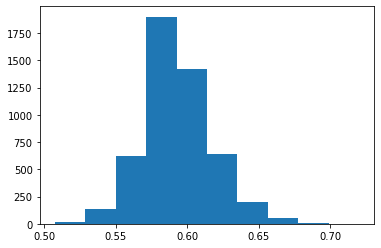

In [358]:
plt.hist(a[1])

(array([ 337.,  567.,  705., 1425.,  690.,  614., 1491.,  754.,  547.,
         370.]),
 array([1.6411335e-06, 1.0000131e-01, 2.0000099e-01, 3.0000064e-01,
        4.0000030e-01, 5.0000000e-01, 5.9999967e-01, 6.9999933e-01,
        7.9999900e-01, 8.9999866e-01, 9.9999833e-01], dtype=float32),
 <BarContainer object of 10 artists>)

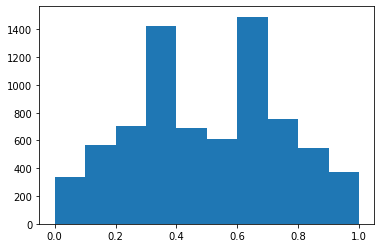

In [233]:
plt.hist()

# Distance based learning

In [236]:
def NL(behaviour, noncontextual=noncontextual):
    return np.min(np.sum(np.reshape(np.abs(behaviour - noncontextual), (5000, -1)), axis=1))

In [250]:
class mlp_r(nn.Module):
    def __init__(self, input_size):
        super(mlp_r, self).__init__()
        self.l1 = nn.Linear(input_size, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.relu(self.l3(x))
        return x

In [251]:
input_size = np.prod(X_train[0].shape)

regressor = mlp_r(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(regressor.parameters(), lr=0.001)

regressor.train()
regressor.to(device)

epochs = 500

In [252]:
next(iter(data_loader_train_r))[1]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.3159, 0.0000, 0.0000, 1.6313, 0.0000,
        0.0000, 0.0000, 1.8028, 0.0000, 0.0000, 1.6711, 0.0000, 0.0000, 1.8024,
        1.6430, 1.4822, 0.0000, 0.0000, 1.5639, 0.0000, 1.2107, 1.6200, 0.0000,
        0.0000, 0.0000, 0.0000, 1.7261, 1.7972, 0.0000, 0.0000, 1.7171, 1.8659,
        0.0000, 1.4501, 1.7921, 0.0000, 0.0000, 1.3289, 0.0000, 1.2694, 0.0000,
        1.2301, 0.0000, 0.0000, 0.0000, 1.3780, 1.6293, 0.0000, 1.2286, 0.0000,
        0.0000, 1.3122, 1.6700, 0.0000, 1.5219, 1.8184, 1.3996, 1.6758, 0.0000,
        0.0000])

In [253]:
for epoch in range(1, epochs):
    epoch_loss = 0
    epoch_acc = 0
    for X, y in data_loader_train_r:
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        y_hat = regressor(X)
        loss = criterion(y_hat, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    if epoch % 20 ==0:
        print(f'Epoch {epoch+0:03}: | Loss: {epoch_loss/len(data_loader_train):.5f} | Acc: {epoch_acc/len(data_loader_train):.3f}')

Epoch 020: | Loss: 0.03282 | Acc: 0.000
Epoch 040: | Loss: 0.02061 | Acc: 0.000
Epoch 060: | Loss: 0.01744 | Acc: 0.000
Epoch 080: | Loss: 0.01567 | Acc: 0.000
Epoch 100: | Loss: 0.01553 | Acc: 0.000
Epoch 120: | Loss: 0.01367 | Acc: 0.000
Epoch 140: | Loss: 0.01615 | Acc: 0.000
Epoch 160: | Loss: 0.01262 | Acc: 0.000
Epoch 180: | Loss: 0.01210 | Acc: 0.000
Epoch 200: | Loss: 0.01167 | Acc: 0.000
Epoch 220: | Loss: 0.01120 | Acc: 0.000
Epoch 240: | Loss: 0.01029 | Acc: 0.000
Epoch 260: | Loss: 0.01003 | Acc: 0.000
Epoch 280: | Loss: 0.01026 | Acc: 0.000
Epoch 300: | Loss: 0.00892 | Acc: 0.000
Epoch 320: | Loss: 0.00893 | Acc: 0.000
Epoch 340: | Loss: 0.00844 | Acc: 0.000
Epoch 360: | Loss: 0.01049 | Acc: 0.000
Epoch 380: | Loss: 0.01265 | Acc: 0.000
Epoch 400: | Loss: 0.00789 | Acc: 0.000
Epoch 420: | Loss: 0.00679 | Acc: 0.000
Epoch 440: | Loss: 0.00662 | Acc: 0.000
Epoch 460: | Loss: 0.00661 | Acc: 0.000
Epoch 480: | Loss: 0.00544 | Acc: 0.000


In [260]:
def flatten(t):
    return [item for sublist in t for item in sublist]

def get_preds_regressor(dataloader):
    regressor.eval()

    y_preds = list()
    y_true = list()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y_hat = regressor(X).cpu().numpy()
            y_preds.append(y_hat)

    return np.concatenate(y_preds, axis=0).squeeze()

(array([4.991e+03, 3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.20564398, 0.41128796, 0.616932  , 0.8225759 ,
        1.0282199 , 1.233864  , 1.439508  , 1.6451519 , 1.8507959 ,
        2.0564399 ], dtype=float32),
 <BarContainer object of 10 artists>)

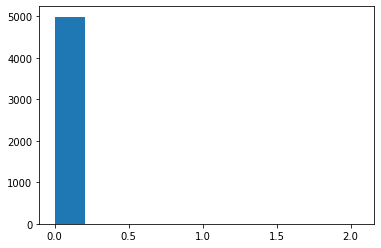

In [255]:
plt.hist(get_preds(noncontextual_data_loader))

(array([   6.,    5.,   18.,  209., 2042., 2100.,  512.,   93.,   11.,
           4.]),
 array([0.       , 0.3131166, 0.6262332, 0.9393498, 1.2524664, 1.565583 ,
        1.8786995, 2.191816 , 2.5049329, 2.8180494, 3.131166 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

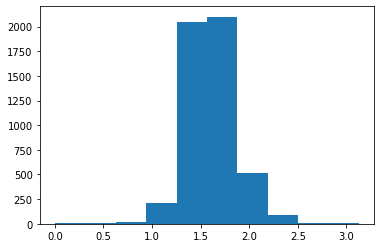

In [256]:
plt.hist(get_preds(contextual_data_loader))

# Correlation investigation

In [379]:
from scipy.stats import pearsonr
preds_regressor = get_preds_regressor(contextual_data_loader)
preds_classifier_raw, preds_classifier_boosted, _ = get_preds_classifier(contextual_data_loader)

corr, _ = pearsonr(preds_regressor/max(preds_regressor), preds_classifier_raw)
print(corr)

0.04595146895806804


In [380]:
corr, _ = pearsonr(preds_regressor/max(preds_regressor), preds_classifier_boosted)
print(corr)

0.36061779001635236


(array([   9.,   54.,  239.,  872., 1799., 1259.,  562.,  176.,   28.,
           2.]),
 array([0.51740193, 0.5556043 , 0.59380656, 0.6320089 , 0.6702112 ,
        0.70841354, 0.7466159 , 0.7848182 , 0.8230205 , 0.8612228 ,
        0.89942515], dtype=float32),
 <BarContainer object of 10 artists>)

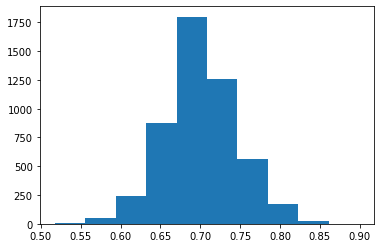

In [381]:
plt.hist(preds_classifier_boosted)

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 4.000e+00, 1.000e+01, 4.981e+03]),
 array([0.7143609 , 0.7429248 , 0.7714887 , 0.80005264, 0.82861656,
        0.8571805 , 0.88574433, 0.91430825, 0.94287217, 0.9714361 ,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

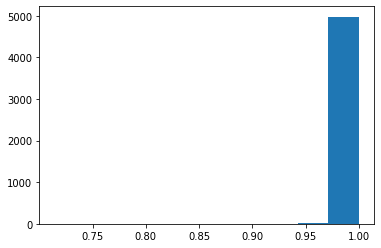

In [382]:
plt.hist(preds_classifier_raw)

(array([   6.,    5.,   18.,  209., 2042., 2100.,  512.,   93.,   11.,
           4.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

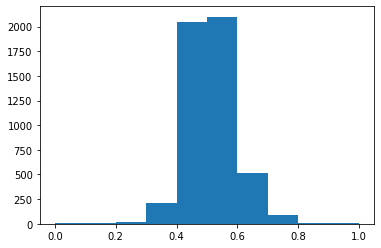

In [383]:
plt.hist(preds_regressor/max(preds_regressor))

# Sampler tests

In [38]:
i=0
j = []
for i in range(10000):
    j.append(np.squeeze(np.reshape(sample(6), (1,-1))))

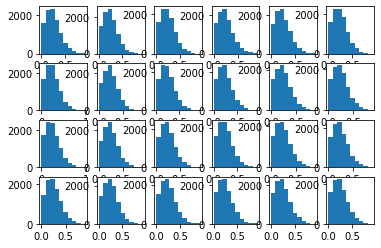

In [39]:
import matplotlib.pyplot as plt
for i in range(24):
    x = [x[i] for x in j]
    ax = plt.subplot(4,6,i+1)
    ax.hist(x)

In [6]:
from itertools import combinations
i=0
j2 = []
for i in range(2000000):
    a = sample(7)
    if i % 20000 == 0:
        print(i)
    if not check_contexuality(a):
        print('hurra')
        i+=1
        j2.append(a)

0
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
260000
hurra
280000
300000
320000
340000
360000
380000
400000
420000
440000
460000
480000
500000
520000
540000
hurra
560000
580000
600000
620000
640000
660000
680000
700000
720000
740000
760000
780000
800000
820000
840000
860000
880000
900000
920000
940000
960000
980000
1000000
1020000
1040000
1060000
1080000
1100000
1120000
1140000
1160000
1180000
1200000
1220000
1240000
1260000
1280000
1300000
1320000
1340000
1360000
1380000
1400000
1420000
1440000
1460000
1480000
1500000
1520000
hurra
1540000
1560000
1580000
1600000
1620000
1640000
1660000
1680000
1700000
1720000
1740000
1760000
1780000
1800000
1820000
1840000
1860000
1880000
1900000
1920000
1940000
1960000
1980000


In [7]:
j2

[array([[0.04369893, 0.01917571, 0.01053557, 0.02494159, 0.85541383,
         0.09107675, 0.15913031],
        [0.18060974, 0.27177971, 0.01503045, 0.03672313, 0.00497633,
         0.77936832, 0.01567735],
        [0.57581613, 0.00639031, 0.05112916, 0.83544856, 0.01503124,
         0.08373091, 0.06517837],
        [0.19987519, 0.70265427, 0.92330482, 0.10288671, 0.1245786 ,
         0.04582402, 0.76001398]]),
 array([[0.12458359, 0.43419257, 0.09336704, 0.4621615 , 0.15427405,
         0.08658109, 0.01654391],
        [0.03429874, 0.00955867, 0.37789389, 0.08230243, 0.31087138,
         0.14300857, 0.82858879],
        [0.12127195, 0.03706836, 0.45109689, 0.00298393, 0.0753156 ,
         0.75855161, 0.14233842],
        [0.71984572, 0.5191804 , 0.07764218, 0.45255215, 0.45953897,
         0.01185873, 0.01252888]]),
 array([[2.94107461e-02, 1.54903812e-01, 8.75319076e-01, 1.17802295e-02,
         1.94822577e-02, 8.90729082e-03, 1.34050661e-01],
        [1.76742074e-01, 8.45148878e-02, 

In [22]:
check_contexuality(j2[2])

(False,
 array([ 0.33540764, -0.28345917, -3.23104162,  0.33174044, -3.37607771,
        -0.50014693, -0.80389516, -0.16810414,  3.39467792, -0.31314023,
         2.56279055,  2.25904232,  0.44709546, -3.26072268, -0.38479191,
        -0.68854013,  0.30205937,  3.17799015,  2.87424192, -0.529828  ,
        -0.83357622,  2.04235456, -0.17177135, -3.87958949, -1.00365872,
        -1.30740694, -0.31680744,  2.55912334,  2.25537512, -1.1486948 ,
        -1.45244303,  1.42348775, -3.26438989, -0.38845912, -0.69220734,
        -4.09627726, -4.40002548, -1.52409471, -0.5334952 , -0.83724343,
         2.03868735, -1.6691308 , -0.20145241,  2.67447836,  2.37073014,
        -1.03333978, -1.337088  ,  1.53884277,  2.52944228,  2.22569405,
         5.10162483,  1.39380669, -0.41814018, -0.7218884 ,  2.15404237,
        -1.55377577,  2.00900629, -1.03700699, -1.34075521,  1.53517556,
        -2.17264258,  1.39013948, -1.55744298,  1.5054945 ]))